<a href="https://colab.research.google.com/github/luisArthurRodriguesDaSilva/estudo-dados-eleicoes/blob/master/mapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# geradores de mapas

##importações

In [1]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import folium
import requests
import pandas as pd
import numpy as np
import json
import pickle as pike
from zipfile import ZipFile
import os
from unidecode import unidecode
from IPython.display import display
import branca.colormap as cmp

In [3]:
brasil_ufs = ['ac','al','am','ap','ba','ce','df','es','go','ma','mt','ms','mg','pa','pb','pr','pe','pi','rj','rn','ro','rs','rr','sc','se','sp','to']
BRASIL_UFS =  list(map(lambda x: x.upper(),brasil_ufs))
ufCodes = pd.read_html('https://www.oobj.com.br/bc/article/quais-os-c%C3%B3digos-de-cada-uf-no-brasil-465.html',match='UF')[0]

In [4]:
path = '/content/drive/MyDrive/electionsData.pkl'
with open(path,'rb') as f:
  electionsData = (pike.load(f))

In [5]:
url = 'https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/brazil-states.geojson'
brazil_geo_json = requests.get(url).json()

##funções

### escopo BRASIL -> UFs

In [18]:
def getScore(uf,candidato):
  info = electionsData[uf]['Presidente']
  candidateData = info[(info['Nome do Candidato']==candidato)]
  return (candidateData['(%) Votos'].values[0])
getScore('rj','JAIR BOLSONARO')

51.09

In [19]:
def generateMap(df,color,candidate):
  mapa = folium.Map(location=[-10, -30], zoom_start=4)

  mapa.choropleth(geo_data=brazil_geo_json, data=df,
                  columns=['state','% Votos'],
                  key_on='properties.sigla',  # Check your GeoJSON for the name!
                  fill_color=color,
                  fill_opacity=0.7, 
                  line_opacity=0.2,legend_name=f'% de Votos para {candidate}')

  return mapa

In [20]:
candColors = {
    'bolsoColor': 'PuBuGn',
    'lulaColor':'OrRd',
    'ciroColor':'PuBuGn'
}

def showCandidateMap(candidate, color):
  votes = list(map(lambda uf:float(getScore(uf,candidate)),brasil_ufs))
  usedDf = pd.DataFrame(np.c_[BRASIL_UFS, votes], columns=['state', '% Votos'])

  usedDf['% Votos'] = pd.Series(votes, dtype=float)
  return generateMap(usedDf,color,candidate)

### escopo UFs -> municípios

In [6]:
def getUfCode(uf):
  return ufCodes[ ufCodes['UF'] == uf.upper()]['Código UF'].values[0]

In [7]:
def getGeoJson(uf):
  code = getUfCode(uf)
  geo_data_uf = requests.get(f'https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-{code}-mun.json').json()

  for index, mun in enumerate(geo_data_uf['features']) :
    geo_data_uf['features'][index]['properties']['name'] = (mun['properties']['name'].upper())
  
  munNames = list(map(lambda x : (x['properties']['name']), (geo_data_uf['features'])))
  return geo_data_uf, munNames

In [8]:
def downloadUfData(uf):
  path = f'/content/bweb_2t_{uf.upper()}_311020221535.csv'
  if not os.path.isfile(path) :
    zipado = requests.get(f'https://cdn.tse.jus.br/estatistica/sead/eleicoes/eleicoes2022/buweb/bweb_2t_{uf.upper()}_311020221535.zip')
    open('zipe.zip','wb').write(zipado.content)

    file_name = "zipe.zip"

    with ZipFile(file_name, 'r') as zip:
      zip.printdir()
      zip.extractall()

In [9]:
def getUfData(uf):
  downloadUfData(uf)
  with open(f'/content/bweb_2t_{uf.upper()}_311020221535.csv','rb') as f:
      munUfData = pd.read_csv(f,sep=";",encoding='latin-1')

  simpleData = munUfData.drop(columns=
                        ['ANO_ELEICAO',
                         'DT_GERACAO',
                         'HH_GERACAO',
                         'CD_TIPO_ELEICAO',
                         'NM_TIPO_ELEICAO',
                         'NR_TURNO',
                         'CD_ELEICAO',
                         ])


  simpUfdata = simpleData.groupby(by= ['NM_MUNICIPIO','NR_PARTIDO']).agg(
    quantidade = ('QT_VOTOS','sum')
  )
  return simpUfdata

In [10]:
def getPP(ufMunData,mun,num):
  #print(mun)
  try :
    bolso = ufMunData['quantidade'][mun][22]
    lula = ufMunData['quantidade'][mun][13]
    totalValid = bolso + lula
    return ufMunData['quantidade'][mun][num] / totalValid
  except Exception as e:
    try:
      bolso = ufMunData['quantidade'][unidecode(mun)][22]
      lula = ufMunData['quantidade'][unidecode(mun)][13]
      totalValid = bolso + lula
      print('passei no segundo try')
      return ufMunData['quantidade'][unidecode(mun)][num] / totalValid
    except:
      print(e)
      return 0.5

In [11]:
def getDfs(ufMunData,munNames) : 
  #print('cheguei no getDfs')
  bolsoScores = list(map(lambda mun : getPP(ufMunData,mun,22),munNames))
  lulaScores = list(map(lambda mun : getPP(ufMunData,mun,13),munNames))
  #print('arrays foram')
  bolsoDf = pd.DataFrame(np.c_[munNames, bolsoScores], columns=['municipio', '% Votos'])
  bolsoDf['% Votos'] = pd.Series(bolsoScores, dtype=float)
  #print('bolso foi')
  lulaDf = pd.DataFrame(np.c_[munNames, lulaScores], columns=['municipio', '% Votos'])
  lulaDf['% Votos'] = pd.Series(lulaScores, dtype=float)
  return lulaDf, bolsoDf

In [12]:

linear = cmp.LinearColormap(
    [(0, 150, 0),(255,255,255), (150,0,0)],
    vmin=0, vmax=100,
    caption='% de votos para Lula'
)
linear

In [ ]:
def generateUfMap(uf):
  geo_data, munNames = getGeoJson(uf)
  center = geo_data['features'][10]['geometry']['coordinates'][0][10]
  ufMunData = getUfData(uf)
  lulaDf,bolsoDf = getDfs(ufMunData,munNames)

  mapa = folium.Map(location=[-16,-45], zoom_start=4.5)
  folium.GeoJson(
    geo_data,
    style_function=lambda feature: {
        'fillColor': linear(lulaDf[lulaDf['municipio'] == feature['properties']['name']].values[0][1]*100),
        'color': 'black',    
        'weight': 1,
        "fillOpacity": 1,
    }).add_to(mapa)
  linear.add_to(mapa)

  folium.LayerControl().add_to(mapa)
  return mapa

### testes

In [ ]:
generateUfMap('rs')

In [ ]:
showCandidateMap('PADRE KELMON',candColors['lulaColor'])

#mapas

mapa RJ

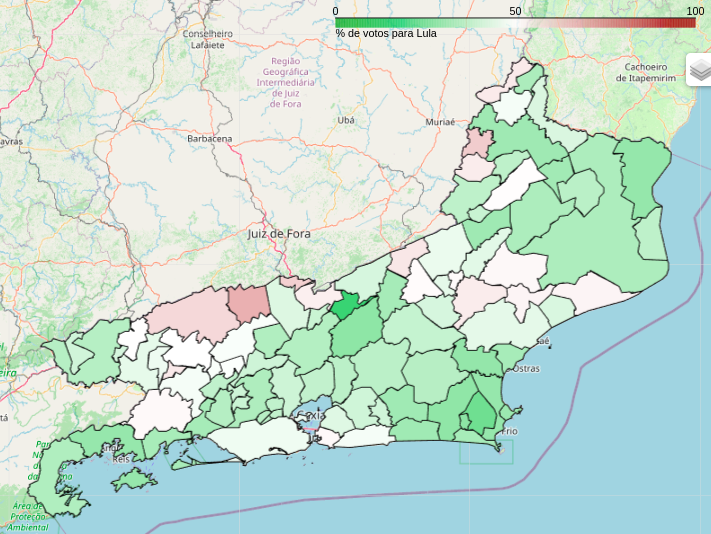

mapa MA

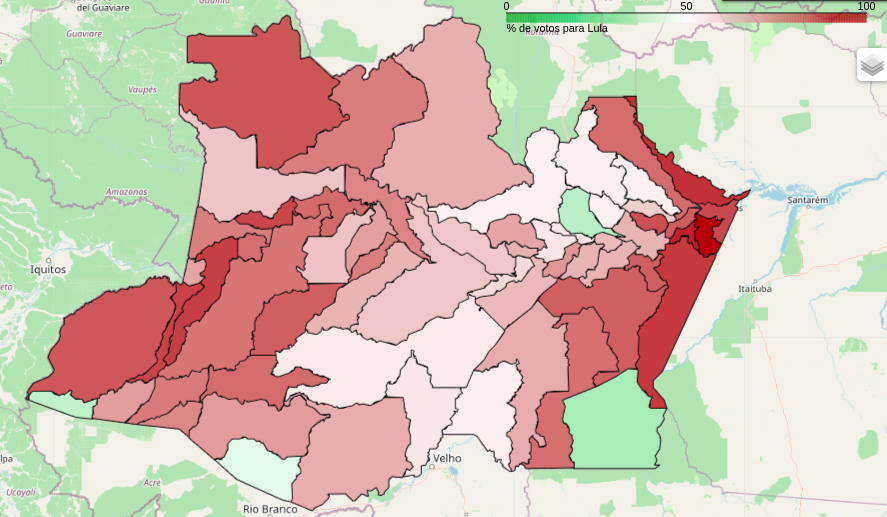

mapa SC

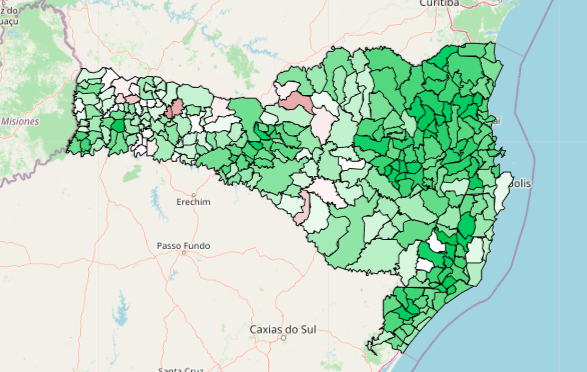